# 5.1-5.2 オフ方策学習における異なるアプローチの性能比較

In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
from sklearn.utils import check_random_state
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.style.use('ggplot')

from dataset import generate_synthetic_data
from policylearners import RegBasedPolicyLearner, GradientBasedPolicyLearner, POTEC
from utils import softmax

### ログデータ(トレーニングデータ)のサイズ$n$を変化させたときの回帰ベース・勾配ベース・POTECの性能の変化

In [2]:
## シミュレーション設定
num_runs = 100 # シミュレーションの繰り返し回数
dim_x = 5 # 特徴量xの次元
num_actions = 500 # 行動数, |A|
num_clusters = 50 # 行動クラスタ数, |C|
lambda_ = 0.5 # クラスタ効果と残差効果の配合率
max_iter = 31 # エポック数
test_data_size = 50000 # テストデータのサイズ
random_state = 12345
torch.manual_seed(random_state)
random_ = check_random_state(random_state)
num_data_list = [100, 200, 500, 1000, 2000] # トレーニングデータのサイズ

In [3]:
## 期待報酬関数を定義するためのパラメータを抽出
phi_a = random_.choice(num_clusters, size=num_actions)
theta_g = random_.normal(size=(dim_x, num_clusters))
M_g = random_.normal(size=(dim_x, num_clusters))
b_g = random_.normal(size=(1, num_clusters))
theta_h = random_.normal(size=(dim_x, num_actions))
M_h = random_.normal(size=(dim_x, num_actions))
b_h = random_.normal(size=(1, num_actions))

## 学習された方策の真の性能を近似するためのテストデータを生成
test_data = generate_synthetic_data(
    num_data=test_data_size, lambda_=lambda_,
    theta_g=theta_g, M_g=M_g, b_g=b_g, theta_h=theta_h, M_h=M_h, b_h=b_h, phi_a=phi_a,
    dim_context=dim_x, num_actions=num_actions, num_clusters=num_clusters, random_state = random_state
)
pi_0_value = (test_data["q_x_a"] * test_data["pi_0"]).sum(1).mean()

result_df_list = []
for num_data in num_data_list:
    test_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data(
            num_data=num_data, lambda_=lambda_,
            theta_g=theta_g, M_g=M_g, b_g=b_g, theta_h=theta_h, M_h=M_h, b_h=b_h, phi_a=phi_a,
            dim_context=dim_x, num_actions=num_actions, num_clusters=num_clusters,
            random_state = _
        )

        true_value_of_learned_policies = dict()
        true_value_of_learned_policies["logging"] = pi_0_value

        ## ログデータを用いてオフ方策学習を実行する
        ### 回帰ベースのアプローチ
        reg = RegBasedPolicyLearner(dim_x=dim_x, num_actions=num_actions, max_iter=max_iter)
        reg.fit(offline_logged_data, test_data)
        pi_reg = reg.predict(test_data)
        true_value_of_learned_policies["reg"] = (test_data["q_x_a"] * pi_reg).sum(1).mean()
        ### 勾配ベースのアプローチ (IPS推定量で方策勾配を推定)
        ips = GradientBasedPolicyLearner(dim_x=dim_x, num_actions=num_actions, max_iter=max_iter)
        ips.fit(offline_logged_data, test_data)
        pi_ips = ips.predict(test_data)
        true_value_of_learned_policies["ips-pg"] = (test_data["q_x_a"] * pi_ips).sum(1).mean()
        ### 勾配ベースのアプローチ (DR推定量で方策勾配を推定)
        dr = GradientBasedPolicyLearner(dim_x=dim_x, num_actions=num_actions, max_iter=max_iter)
        q_hat = offline_logged_data["q_x_a"] + random_.normal(scale=1/3, size=(num_data, num_actions))
        dr.fit(offline_logged_data, test_data, q_hat=q_hat)
        pi_dr = dr.predict(test_data)
        true_value_of_learned_policies["dr-pg"] = (test_data["q_x_a"] * pi_dr).sum(1).mean()
        ### POTECアルゴリズム
        potec = POTEC(dim_x=dim_x, num_actions=num_actions, num_clusters=num_clusters, max_iter=max_iter)
        f_hat = offline_logged_data["h_x_a"] + random_.normal(scale=1/2, size=(num_data, num_actions))
        f_hat_test = test_data["h_x_a"] + random_.normal(scale=1/2, size=test_data["h_x_a"].shape)
        potec.fit(offline_logged_data, test_data, f_hat=f_hat, f_hat_test=f_hat_test)
        pi_potec = potec.predict(test_data, f_hat_test=f_hat_test)
        true_value_of_learned_policies["potec"] = (test_data["q_x_a"] * pi_potec).sum(1).mean()

        test_policy_value_list.append(true_value_of_learned_policies)

    ## シミュレーション結果の集計
    result_df = DataFrame(test_policy_value_list).stack().reset_index(1)\
        .rename(columns={"level_1": "method", 0: "value"})
    result_df["num_data"] = num_data
    result_df["pi_0_value"] = pi_0_value
    result_df["rel_value"] = result_df["value"] / pi_0_value
    result_df_list.append(result_df)
result_df_data = pd.concat(result_df_list).reset_index(level=0)


num_data=2000...: 100%|██████████| 100/100 [1:26:09<00:00, 51.69s/it]


### 行動数$|A|$を変化させたときの回帰ベース・勾配ベース・POTECの性能の変化

In [4]:
## シミュレーション設定
num_runs = 100 # シミュレーションの繰り返し回数
dim_x = 5 # 特徴量xの次元
lambda_ = 0.5 # クラスタ効果と残差効果の配合率
num_data = 500 # トレーニングデータのサイズ
max_iter = 31 # エポック数
test_data_size = 50000 # テストデータのサイズ
random_state = 12345
torch.manual_seed(random_state)
random_ = check_random_state(random_state)
num_actions_list = [50, 100, 200, 500, 1000, 2000, 5000] # 行動数, |A|

In [5]:
result_df_list = []
for num_actions in num_actions_list:
    num_clusters = np.int32(0.1 * num_actions) # 行動クラスタ数, |C|

    ## 期待報酬関数を定義するためのパラメータを抽出
    phi_a = random_.choice(num_clusters, size=num_actions)
    theta_g = random_.normal(size=(dim_x, num_clusters))
    M_g = random_.normal(size=(dim_x, num_clusters))
    b_g = random_.normal(size=(1, num_clusters))
    theta_h = random_.normal(size=(dim_x, num_actions))
    M_h = random_.normal(size=(dim_x, num_actions))
    b_h = random_.normal(size=(1, num_actions))

    ## 学習された方策の真の性能を近似するためのテストデータを生成
    test_data = generate_synthetic_data(
        num_data=test_data_size, lambda_=lambda_,
        theta_g=theta_g, M_g=M_g, b_g=b_g, theta_h=theta_h, M_h=M_h, b_h=b_h, phi_a=phi_a,
        dim_context=dim_x, num_actions=num_actions, num_clusters=num_clusters, random_state = random_state
    )
    pi_0_value = (test_data["q_x_a"] * test_data["pi_0"]).sum(1).mean()

    test_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"num_actions={num_actions}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data(
            num_data=num_data, lambda_=lambda_,
            theta_g=theta_g, M_g=M_g, b_g=b_g, theta_h=theta_h, M_h=M_h, b_h=b_h, phi_a=phi_a,
            dim_context=dim_x, num_actions=num_actions, num_clusters=num_clusters,
            random_state = _
        )

        true_value_of_learned_policies = dict()
        true_value_of_learned_policies["logging"] = pi_0_value

        ## ログデータを用いてオフ方策学習を実行する
        ### 回帰ベースのアプローチ
        reg = RegBasedPolicyLearner(dim_x=dim_x, num_actions=num_actions, max_iter=max_iter)
        reg.fit(offline_logged_data, test_data)
        pi_reg = reg.predict(test_data)
        true_value_of_learned_policies["reg"] = (test_data["q_x_a"] * pi_reg).sum(1).mean()
        ### 勾配ベースのアプローチ (IPS推定量で方策勾配を推定)
        ips = GradientBasedPolicyLearner(dim_x=dim_x, num_actions=num_actions, max_iter=max_iter)
        ips.fit(offline_logged_data, test_data)
        pi_ips = ips.predict(test_data)
        true_value_of_learned_policies["ips-pg"] = (test_data["q_x_a"] * pi_ips).sum(1).mean()
        ### 勾配ベースのアプローチ (DR推定量で方策勾配を推定)
        dr = GradientBasedPolicyLearner(dim_x=dim_x, num_actions=num_actions, max_iter=max_iter)
        q_hat = offline_logged_data["q_x_a"] + random_.normal(scale=1/3, size=(num_data, num_actions))
        dr.fit(offline_logged_data, test_data, q_hat=q_hat)
        pi_dr = dr.predict(test_data)
        true_value_of_learned_policies["dr-pg"] = (test_data["q_x_a"] * pi_dr).sum(1).mean()
        ### POTECアルゴリズム
        potec = POTEC(dim_x=dim_x, num_actions=num_actions, num_clusters=num_clusters, max_iter=max_iter)
        f_hat = offline_logged_data["h_x_a"] + random_.normal(scale=1/2, size=(num_data, num_actions))
        f_hat_test = test_data["h_x_a"] + random_.normal(scale=1/2, size=test_data["h_x_a"].shape)
        potec.fit(offline_logged_data, test_data, f_hat=f_hat, f_hat_test=f_hat_test)
        pi_potec = potec.predict(test_data, f_hat_test=f_hat_test)
        true_value_of_learned_policies["potec"] = (test_data["q_x_a"] * pi_potec).sum(1).mean()

        test_policy_value_list.append(true_value_of_learned_policies)

    ## シミュレーション結果の集計
    result_df = DataFrame(test_policy_value_list).stack().reset_index(1)\
        .rename(columns={"level_1": "method", 0: "value"})
    result_df["num_actions"] = num_actions
    result_df["pi_0_value"] = pi_0_value
    result_df["rel_value"] = result_df["value"] / pi_0_value
    result_df_list.append(result_df)
result_df_actions = pd.concat(result_df_list).reset_index(level=0)


num_actions=5000...: 100%|██████████| 100/100 [26:39:46<00:00, 959.86s/it]  


## 図5.4

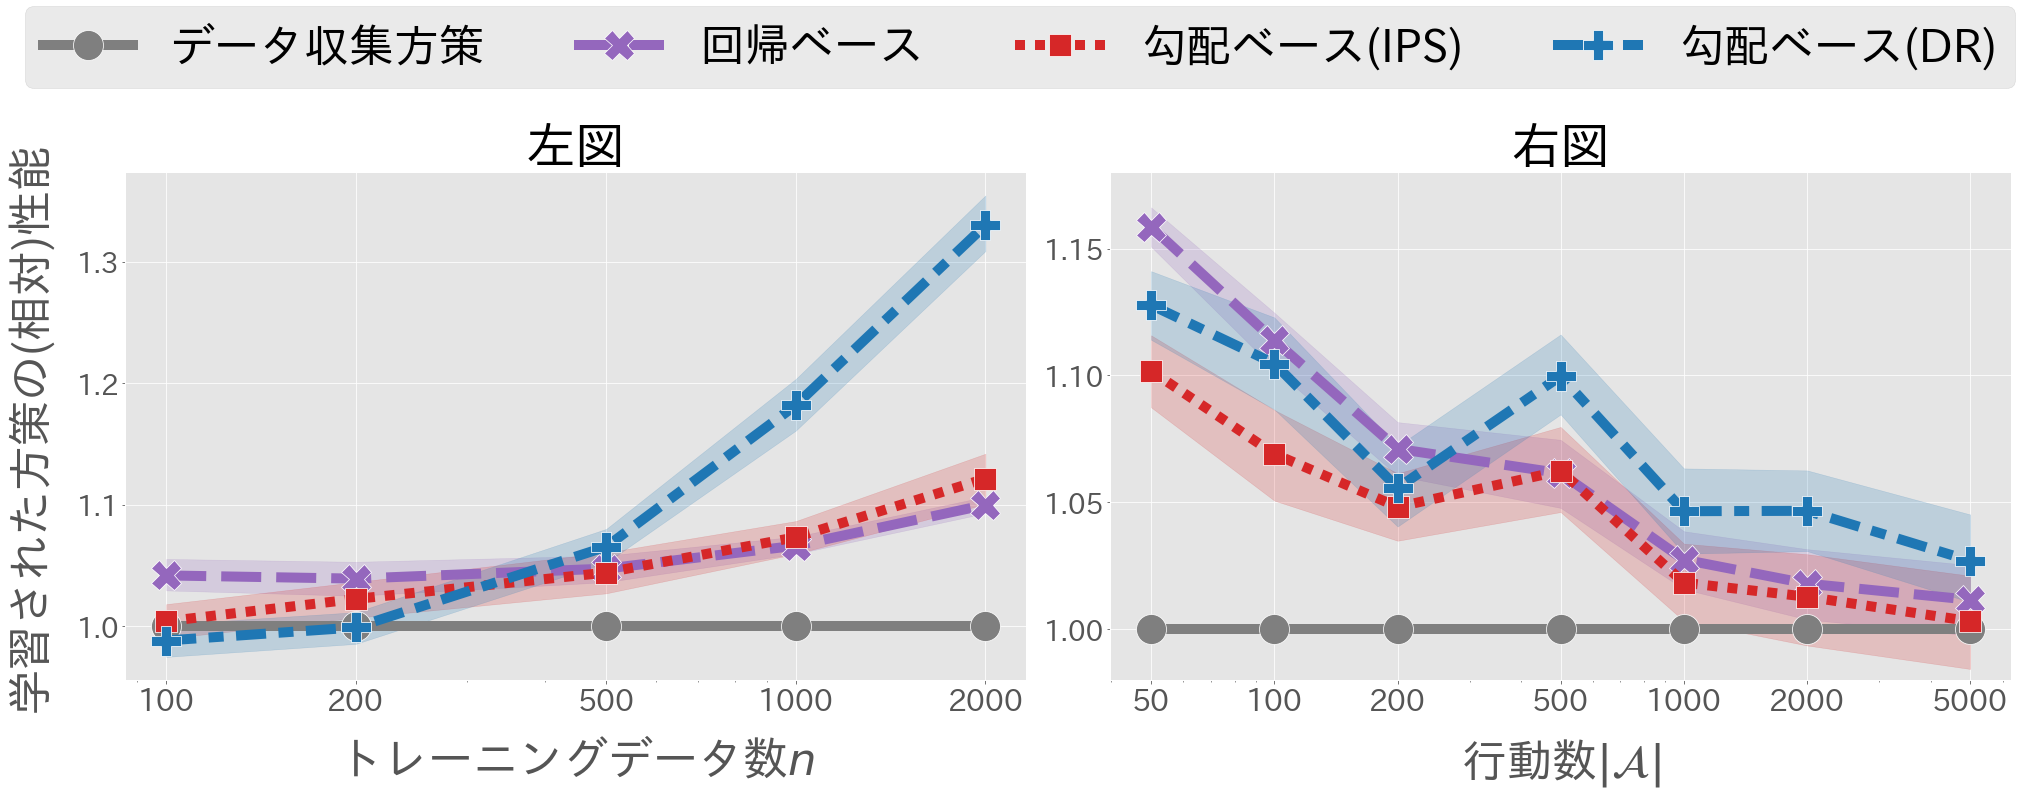

In [10]:
fig, ax_list = plt.subplots(1, 2, figsize=(28, 9.5), tight_layout=True)
y_label_dict = {"num_data": "左図", "num_actions": "右図"}
for i, (x, result_df) in enumerate(zip(["num_data", "num_actions"], [result_df_data, result_df_actions])):
    if i == 1:
        result_df = result_df.query("num_actions >= 50")
    ax = ax_list[i]
    sns.lineplot(
        linewidth=10,
        markersize=30,
        markers=True,
        x=x,
        y="rel_value",
        hue="method",
        style="method",
        ax=ax,
        palette=["tab:grey", "tab:purple", "tab:red", "tab:blue"],
        legend=False,
        data=result_df.query("method != 'potec'"),
    )
    ax.set_title(y_label_dict[x], fontsize=50)
    # yaxis
    if i == 0:
        ax.set_ylabel(r"学習された方策の(相対)性能", fontsize=45)
        ax.set_yticks([1.0, 1.1, 1.2, 1.3])
    else:
        ax.set_ylim(0.98, 1.18)
        ax.set_yticks([1.0, 1.05, 1.1, 1.15])
        ax.set_ylabel("")
    ax.tick_params(axis="y", labelsize=28)
    ax.yaxis.set_label_coords(-0.08, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 0:
        ax.set_xlabel("トレーニングデータ数$n$", fontsize=45)
        ax.set_xticks(num_data_list)
        ax.set_xticklabels(num_data_list, fontsize=30)
    else:
        ax.set_xlabel("行動数$|\mathcal{A}|$", fontsize=45)
        ax.set_xticks(num_actions_list)
        ax.set_xticklabels(num_actions_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.11)
fig.legend(
    ["データ収集方策", "回帰ベース", "勾配ベース(IPS)", "勾配ベース(DR)"], fontsize=45,
    bbox_to_anchor=(0.5, 1.1), ncol=5, loc="center",
)


## 図5.9

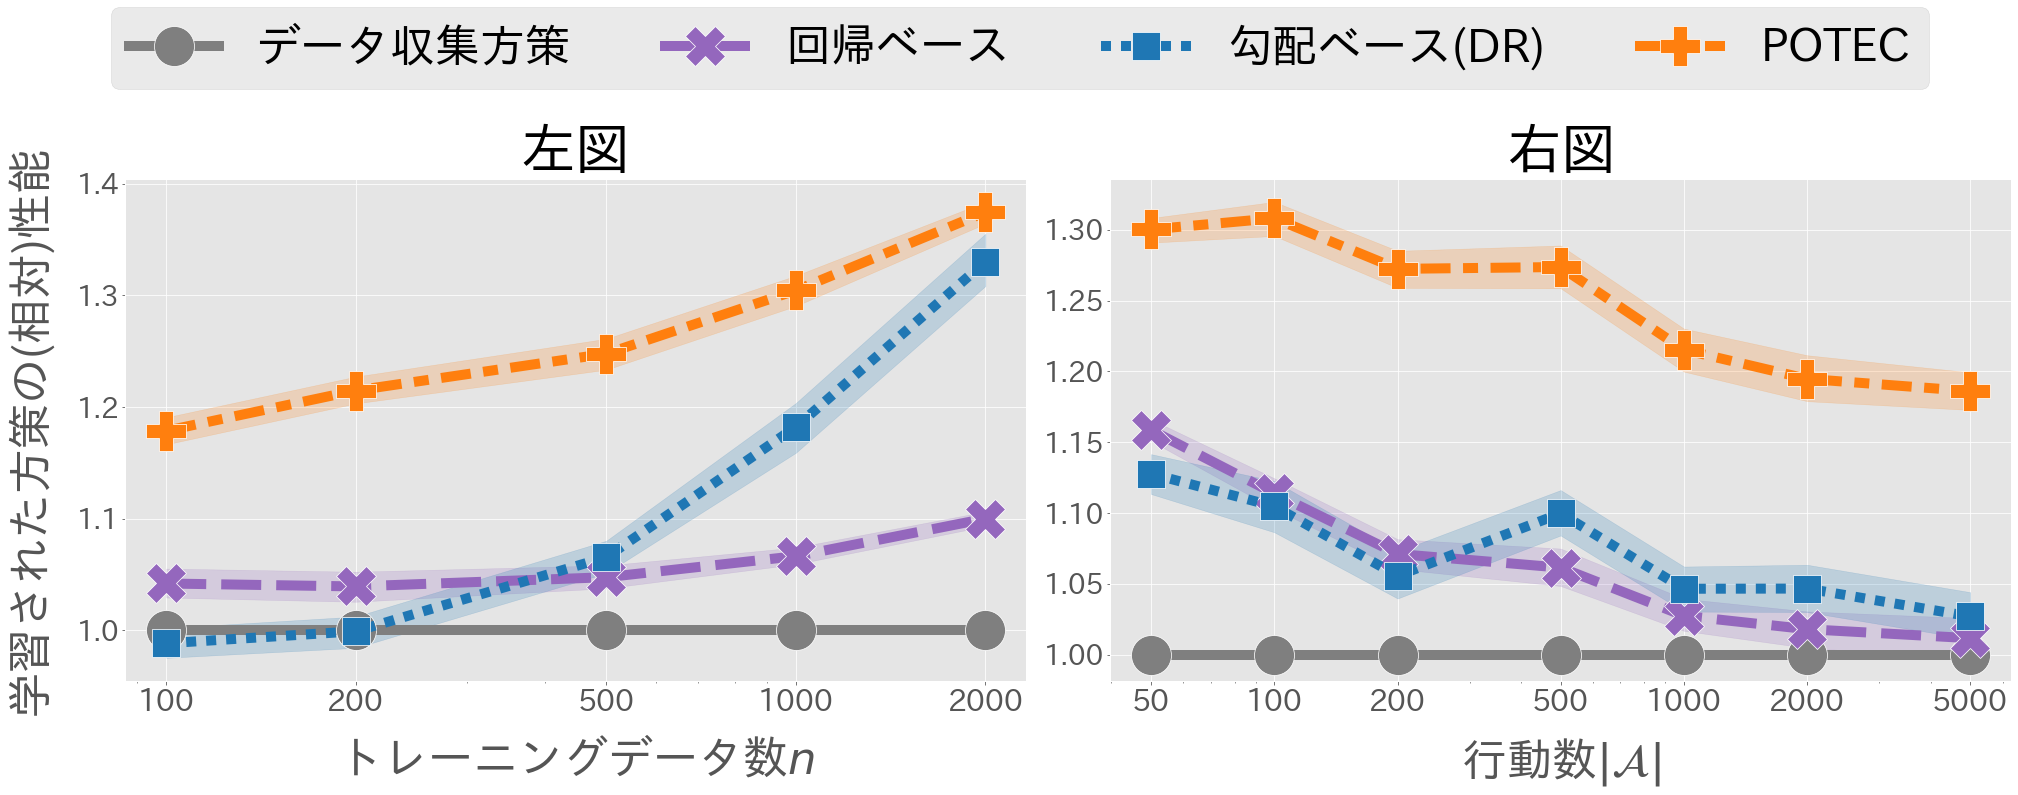

In [9]:
fig, ax_list = plt.subplots(1, 2, figsize=(28, 9.5), tight_layout=True)
y_label_dict = {"num_data": "左図", "num_actions": "右図"}
for i, (x, result_df) in enumerate(zip(["num_data", "num_actions"], [result_df_data, result_df_actions])):
    ax = ax_list[i]
    sns.lineplot(
        linewidth=10,
        markersize=40,
        markers=True,
        x=x,
        y="rel_value",
        hue="method",
        style="method",
        ax=ax,
        palette=["tab:grey", "tab:purple", "tab:blue", "tab:orange"],
        legend=False,
        data=result_df.query("method != 'ips-pg'"),
    )
    ax.set_title(y_label_dict[x], fontsize=55)
    # yaxis
    if i == 0:
        ax.set_ylabel(r"学習された方策の(相対)性能", fontsize=45)
    else:
        ax.set_ylabel("")
    ax.tick_params(axis="y", labelsize=28)
    ax.yaxis.set_label_coords(-0.08, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 0:
        ax.set_xlabel("トレーニングデータ数$n$", fontsize=45)
        ax.set_xticks(num_data_list)
        ax.set_xticklabels(num_data_list, fontsize=30)
    else:
        ax.set_xlabel("行動数$|\mathcal{A}|$", fontsize=45)
        ax.set_xticks(num_actions_list)
        ax.set_xticklabels(num_actions_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.11)
fig.legend(
    ["データ収集方策", "回帰ベース", "勾配ベース(DR)", "POTEC"], fontsize=45,
    bbox_to_anchor=(0.5, 1.1), ncol=5, loc="center",
)
